In [1]:
import matplotlib
%matplotlib inline    
from sklearn_pipeline_enhancements.pipeline_visualization.build_pipeline_rep import draw_pipeline_visualization


## Example of a feature union taken from:
http://scikit-learn.org/stable/auto_examples/feature_stacker.html#sphx-glr-auto-examples-feature-stacker-py

In [2]:
# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

# grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
# grid_search.fit(X, y)
# print(grid_search.best_estimator_)

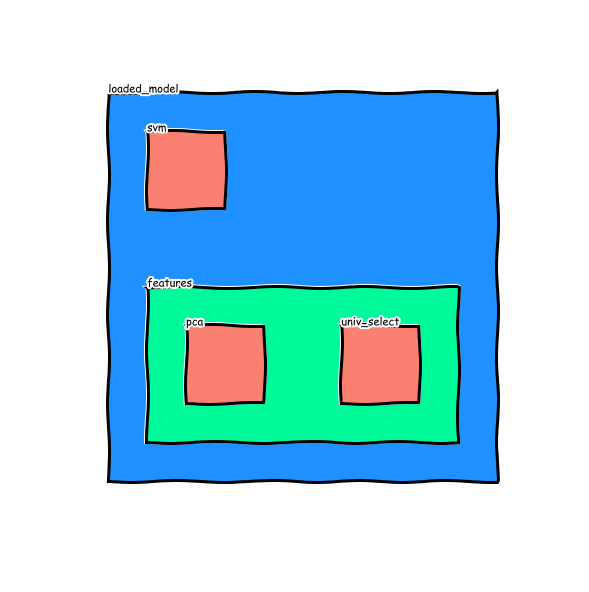

In [3]:
draw_pipeline_visualization(pipeline)

### More complicated feature union taken from:
http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py

In [4]:
# Author: Matt Terry <matt.terry@gmail.com>
#
# License: BSD 3 clause
from __future__ import print_function

import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
from sklearn.datasets.twenty_newsgroups import strip_newsgroup_quoting
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text),
                 'num_sentences': text.count('.')}
                for text in posts]


class SubjectBodyExtractor(BaseEstimator, TransformerMixin):
    """Extract the subject & body from a usenet post in a single pass.

    Takes a sequence of strings and produces a dict of sequences.  Keys are
    `subject` and `body`.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        features = np.recarray(shape=(len(posts),),
                               dtype=[('subject', object), ('body', object)])
        for i, text in enumerate(posts):
            headers, _, bod = text.partition('\n\n')
            bod = strip_newsgroup_footer(bod)
            bod = strip_newsgroup_quoting(bod)
            features['body'][i] = bod

            prefix = 'Subject:'
            sub = ''
            for line in headers.split('\n'):
                if line.startswith(prefix):
                    sub = line[len(prefix):]
                    break
            features['subject'][i] = sub

        return features


pipeline = Pipeline([
    # Extract the subject & body
    ('subjectbody', SubjectBodyExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('subject', Pipeline([
                ('selector', ItemSelector(key='subject')),
                ('tfidf', TfidfVectorizer(min_df=50)),
            ])),

            # Pipeline for standard bag-of-words model for body
            ('body_bow', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ])),

            # Pipeline for pulling ad hoc features from post's body
            ('body_stats', Pipeline([
                ('selector', ItemSelector(key='body')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'subject': 0.8,
            'body_bow': 0.5,
            'body_stats': 1.0,
        },
    )),

    # Use a SVC classifier on the combined features
    ('svc', SVC(kernel='linear')),
])

# limit the list of categories to make running this example faster.
# categories = ['alt.atheism', 'talk.religion.misc']
# train = fetch_20newsgroups(random_state=1,
#                            subset='train',
#                            categories=categories,
#                            )
# test = fetch_20newsgroups(random_state=1,
#                           subset='test',
#                           categories=categories,
#                           )

# pipeline.fit(train.data, train.target)
# y = pipeline.predict(test.data)
# print(classification_report(y, test.target))

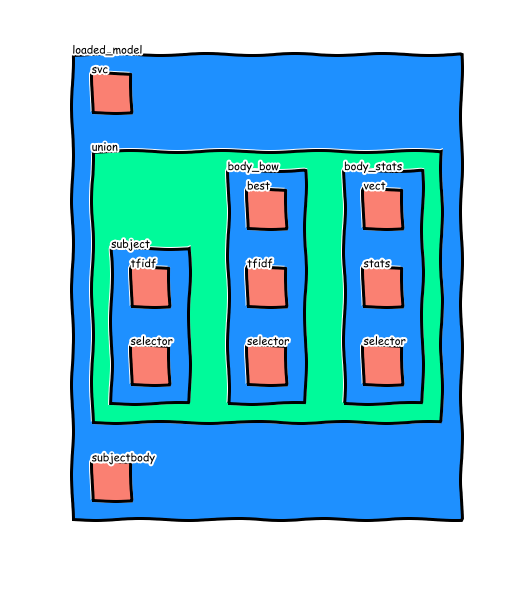

In [5]:
draw_pipeline_visualization(pipeline)